In [1]:
!nvidia-smi

Sun Jan  2 13:45:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
tf.__version__

'2.7.0'

In [3]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

# Load and prepare the MNIST

We will only use the train dataset to train the generator and discriminator.

In [4]:
(images, labels), (_, _) = tf.keras.datasets.mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [5]:
images

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [6]:
images = images.reshape(images.shape[0], 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5  # Normalize the images to [-1, 1]
# images = images / 255.0 (Some errors need to learn about later on)

In [ ]:
images

array([[[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        ...,

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]]],


       [[[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [-1.],
         [-1.]],

        [[-1.],
         [-1.],
         [-1.],
         ...,
         [-1.],
         [

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

# Create the models

## The Generator

The generator uses `tf.keras.layers.Conv2DTranspose` (upsampling) layers to produce an image from a seed (random noise). Start with a `Dense` layer that takes this seed as input, then upsample several times until you reach the desired image size of 28x28x1. Notice the `tf.keras.layers.LeakyReLU` activation for each layer, except the output layer which uses tanh.

In [10]:
def generator_model():
  model = tf.keras.Sequential()
  model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7, 7, 256)))
  assert model.output_shape == (None, 7, 7, 256) # None is the batch size

  model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
  assert model.output_shape == (None, 7, 7, 128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
  assert model.output_shape == (None, 14, 14, 64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape == (None, 28, 28, 1)
  print(model.summary())

  return model

Testing the generator to generate and image instance.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

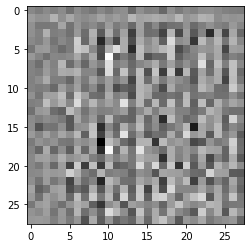

In [11]:
generator = generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

## The discriminator

The discriminator is a CNN-based image classifier.

In [12]:
def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
  print(model.output_shape)
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))
  

  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  print(model.output_shape)
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten())
  model.add(layers.Dense(1))
  print(model.summary())

  return model

Use the discriminator to classify the generated image. Positive value for real and negative value for fake.

In [13]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
decision
# (5 x 5 + 1) x 64
# (5 x 5 x 64 + 1) x 128
# 7 x 7 x 128 + 1(bias)

(None, 14, 14, 64)
(None, 7, 7, 128)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00248908]], dtype=float32)>

# Define the loss and optimizers

In [14]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

## Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [15]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

## Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [16]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

## Optimizer

In [17]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

## Save checkpoints

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Training loop

In [19]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

# Reuse this seed overtime (so it's easier)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [20]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
  # noise = tf.random.normal([BATCH_SIZE, noise_dim])
  noise = tf.random.normal([BATCH_SIZE, noise_dim]) / 2

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    # Training process
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # Calculate loss
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Calculate gradient
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Back probagation
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [21]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch + 1, seed)

    # Save the model every 5 epochs
    if (epoch + 1) % 5 == 0:
      checkpoint.save(file_prefix= checkpoint_prefix)
    
    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

  display.clear_output(wait=True)
  generate_and_save_images(generator, epochs, seed)

## Generate and save images

In [22]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i + 1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      # plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

# Train the model

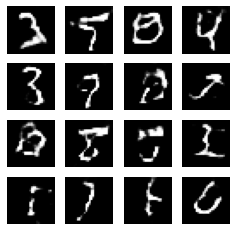

In [23]:
train(train_dataset, EPOCHS)

In [ ]:
# !zip -r /content/checkpoint.zip /content/training_checkpoints
# from google.colab import files
# files.download("/content/checkpoint.zip")

In [25]:
from google.colab import files

for i in range(1, 11):
  path = '/content/image_at_epoch_{:04d}.png'.format(i)
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
for i in range(11, 21):
  path = '/content/image_at_epoch_{:04d}.png'.format(i)
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
for i in range(21, 31):
  path = '/content/image_at_epoch_{:04d}.png'.format(i)
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
for i in range(31, 41):
  path = '/content/image_at_epoch_{:04d}.png'.format(i)
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
for i in range(41, 51):
  path = '/content/image_at_epoch_{:04d}.png'.format(i)
  files.download(path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>